In [29]:
import os
import time
import torch
import tqdm.notebook as tqdm
import numpy as np
from model import RVAE
from multiprocessing import cpu_count
from data_loader_RVAE import import_dataset, tensor_to_sentence
from torch.utils.data import DataLoader, TensorDataset

In [30]:
PITCH_LIST = ["A", "A#", "B", "C", "C#", "D", "D#", "E", "F", "F#", "G", "G#"]
MAIN_QUALITY_LIST = ["maj", "min", "dim"]
EXTRA_QUALITY_LIST = ["N", "maj7", "min7"] # "None", "+ major 7th", "+ minor 7th"

TOTAL_MAIN = len(PITCH_LIST) * len(MAIN_QUALITY_LIST)

In [48]:
def set_dict_chord_to_int():
    chord_to_int = {
        "START" : 0,
        "END" : 1,
        "N" : 2
    }
    n = 3
    for pitch in PITCH_LIST:
        for main_q in MAIN_QUALITY_LIST:
            for extra_q in EXTRA_QUALITY_LIST:
                chord_to_int[f"{pitch}:{main_q}:{extra_q}"] = n
                n += 1
    return chord_to_int


def update_confusion_matrix(conf_matrix, chord_to_int, real_sentence, recons_sentence):
    for i in range(len(real_sentence)):
        chord_real = real_sentence[i]
        chord_recons = recons_sentence[i]
        conf_matrix[chord_to_int[chord_real], chord_to_int[chord_recons]] += 1

In [56]:
one_hots, len_sentences = import_dataset()
len_sentences = torch.from_numpy(len_sentences)
model = RVAE(torch.max(len_sentences))
model.load_state_dict(torch.load("./E9.pt", map_location=torch.device('cpu')))
print("Model loaded !")
print(model)


dataset = TensorDataset(one_hots, len_sentences)
data_loader = DataLoader(
    dataset=dataset,
    batch_size=1,
    num_workers=cpu_count(),
    pin_memory=torch.cuda.is_available()
)

conf_matrix = np.zeros((TOTAL_MAIN * len(EXTRA_QUALITY_LIST) + 3, TOTAL_MAIN * len(EXTRA_QUALITY_LIST) + 3))
chord_to_int = set_dict_chord_to_int()

print(chord_to_int)

Dataset loaded !
Model loaded !
RVAE(
  (encoder_rnn): GRU(42, 256, batch_first=True)
  (decoder_rnn): GRU(42, 256, batch_first=True)
  (hidden2mean): Linear(in_features=256, out_features=16, bias=True)
  (hidden2logv): Linear(in_features=256, out_features=16, bias=True)
  (latent2hidden): Linear(in_features=16, out_features=256, bias=True)
  (outputs2pred): Linear(in_features=256, out_features=42, bias=True)
)
torch.Size([1383, 1022, 42])
{'START': 0, 'END': 1, 'N': 2, 'A:maj:N': 3, 'A:maj:maj7': 4, 'A:maj:min7': 5, 'A:min:N': 6, 'A:min:maj7': 7, 'A:min:min7': 8, 'A:dim:N': 9, 'A:dim:maj7': 10, 'A:dim:min7': 11, 'A#:maj:N': 12, 'A#:maj:maj7': 13, 'A#:maj:min7': 14, 'A#:min:N': 15, 'A#:min:maj7': 16, 'A#:min:min7': 17, 'A#:dim:N': 18, 'A#:dim:maj7': 19, 'A#:dim:min7': 20, 'B:maj:N': 21, 'B:maj:maj7': 22, 'B:maj:min7': 23, 'B:min:N': 24, 'B:min:maj7': 25, 'B:min:min7': 26, 'B:dim:N': 27, 'B:dim:maj7': 28, 'B:dim:min7': 29, 'C:maj:N': 30, 'C:maj:maj7': 31, 'C:maj:min7': 32, 'C:min:N': 33

In [57]:
pbar = tqdm.tqdm(total = len(data_loader))

for iteration, (seq_data, length) in enumerate(data_loader):
    # print(seq_data.shape, length)
    recons_data, mean, logv, z = model(seq_data, length)
    real_sentence = tensor_to_sentence(seq_data[0], length[0])
    recons_sentence = tensor_to_sentence(recons_data[0], length[0])
    update_confusion_matrix(conf_matrix, chord_to_int, real_sentence, recons_sentence)
    pbar.update(1)

pbar.close()

<ipython-input-58-4f13898f87a3>:7: RuntimeWarning: divide by zero encountered in log
  mat_plt = ax.imshow(np.log(conf_matrix))


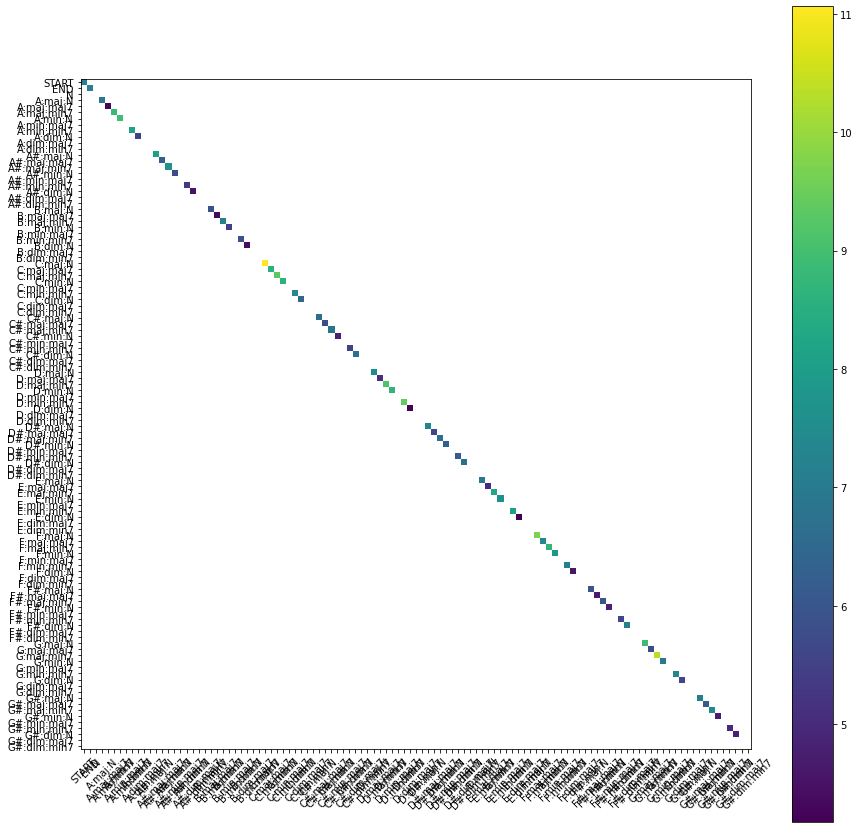

In [58]:
import matplotlib.pyplot as plt

list_ticks = [key for key in chord_to_int]


fig, ax = plt.subplots(1,1, figsize=(15,15))
mat_plt = ax.imshow(np.log(conf_matrix))
ax.set_xticks(np.arange(len(list_ticks)))
ax.set_yticks(np.arange(len(list_ticks)))
ax.set_yticklabels(list_ticks)
ax.set_xticklabels(list_ticks)
plt.xticks(rotation=45)
plt.colorbar(mat_plt)
plt.show()